In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ten

In [2]:

datadir = 'Data/AAI/'

In [15]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

def read_data(globpattern):
    ifiles = glob.glob(globpattern) #'Data/AAI/tiffs_FSS_24h*.mm')
    ammdict = dict()
    for i in ifiles:
        amm = read_mm(i)
        amm_m = amm.mean(axis=(1,2), keepdims=True)
        amm_std = amm.std(axis=(1,2), keepdims=True)
        amm = (amm - amm_m)/amm_std
        #print(amm.shape)
        ammdict[i.split('/')[-1]] = amm
   
    return ammdict

ammdict = read_data('Data/AAI/tiffs_*.mm')

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


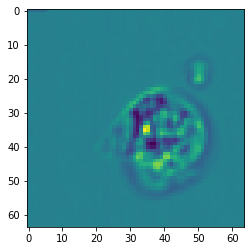

In [16]:
xb = ammdict['tiffs_FSS_24h_e.mm'][1]
plt.imshow(xb[:,:,0])

In [4]:
datafile = '/home/cjw/Code/DeepLearning/classifier/Data/images.mm'
labelsfile = '/home/cjw/Code/DeepLearning/classifier/Data/labels.mm'

labels = np.memmap(labelsfile, dtype=np.float32)
data = np.memmap(datafile, dtype=np.float32)
data = data.reshape((-1, 64, 64, 5))
labels = labels.reshape((data.shape[0], -1))
data = data[:,:,:,[0,2,4]]

dm = data.mean(axis=(1,2), keepdims=True)
dstd= data.std(axis=(1,2), keepdims=True)
data = (data - dm)/dstd
data.shape, labels.shape

((35469, 64, 64, 3), (35469, 9))

In [5]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


In [6]:
ammdict.keys()

dict_keys(['tiffs_FSS_24h_e.mm', 'tiffs_LPS_24h_d.mm', 'tiffs_LPS_24h_f.mm', 'tiffs_LPS_24h_a.mm', 'tiffs_FSS_24h_d.mm', 'tiffs_FSS_72h_b.mm', 'tiffs_LPS_24h_b.mm', 'tiffs_LPS_72h_c.mm', 'tiffs_LPS_72h_e.mm', 'tiffs_FSS_24h_c.mm', 'tiffs_FSS_24h_b.mm', 'tiffs_FSS_72h_e.mm', 'tiffs_LPS_72h_f.mm', 'tiffs_FSS_72h_a.mm', 'tiffs_FSS_72h_c.mm', 'tiffs_FSS_72h_f.mm', 'tiffs_LPS_72h_a.mm', 'tiffs_FSS_72h_d.mm', 'tiffs_LPS_72h_d.mm', 'tiffs_LPS_24h_e.mm', 'tiffs_FSS_24h_f.mm', 'tiffs_FSS_24h_a.mm', 'tiffs_LPS_24h_c.mm', 'tiffs_LPS_72h_b.mm'])

In [7]:
cpdir = 'Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

cpmeta = cpdir + checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, cpdir + checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/best-checkpoint-21300


In [8]:
pq = 'dense_1/BiasAdd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(128,) dtype=float32>]


In [9]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

In [10]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [11]:
data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

(array([38.00499 , 45.903652, 22.687044], dtype=float32),
 array([-27.450594  ,  -2.3133378 ,  -0.84589547], dtype=float32))

In [12]:
for k, v in ammdict.items():
    #print(k, v.shape)
    amm = ammdict[k]
    mask = np.any(np.isnan(amm), axis=(1,2,3))
    amm = amm[~mask]
    ammdict[k] = amm

In [13]:
gt = labels.argmax(axis=-1)
gt.shape, gt[-10:]

((35469,), array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4]))

In [14]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
d1, r1, p1 = sess.run([a, b, sm], feed_dict={images:data[:, 16:48, 16:48, :]})

p1x = np.argmax(p1, axis=-1)
df1 = pd.DataFrame({'sm':p1x, 'smmax':p1.max(axis=-1), 'gt':gt})
gtmap = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 8:0, 7:4}
df1['gtc'] = df1['gt'].map(gtmap)
#d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:amm[:, 16:48, 16:48, :]})

In [15]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
adflist = list()
d2list = list()
for k, v in ammdict.items():
    d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:v[:, 16:48, 16:48, :]})
    d2list.append(r2)
    p2x = np.argmax(p2, axis=-1)
    s = k.split('_')
    dataset = "{} {} {}".format(s[1], s[2], s[3][0])
    xdf = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1), 'dataset':dataset})
    adflist.append(xdf)

adf = pd.concat(adflist, axis=0)
d2array = np.concatenate(d2list)
d2array.shape

(196311, 128)

In [16]:

#sns.distplot(adf['smmax'])


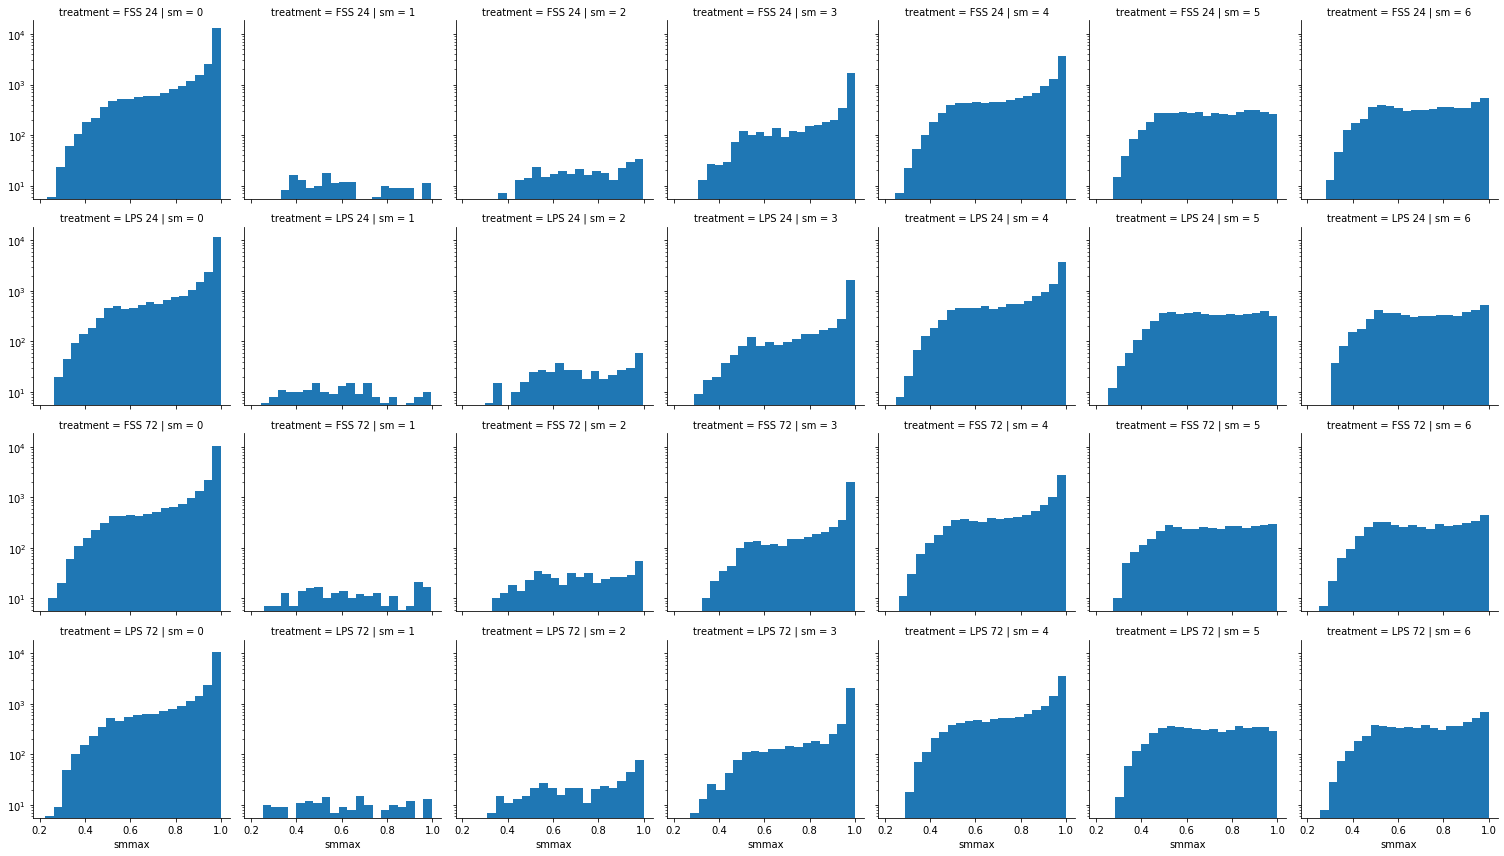

In [17]:
adf['treatment'] = adf['dataset'].str.split("h ", expand=True)[0]
g = sns.FacetGrid(adf, col='sm', row='treatment')
g = g.map(plt.hist, "smmax", bins=20, log=True)

In [39]:
adf.to_pickle("adf_pickle.pkl")

In [37]:
#gdf = adf.groupby(['sm', 'treatment', pd.cut(adf["smmax"], [0, 0.4, 1])]).agg({'dataset':'count'})
binlabs = ["low", "high"]
adf['bin'] = pd.cut(adf["smmax"], [0, 0.3, 1], labels=binlabs)
print(adf.head())

topv = adf.groupby(['dataset', 'sm', 'bin']).agg('count').reset_index()
print(topv.head())

tlist = list()
smlist = list()
hlist = list()
lowlist = list()

high = topv[topv.loc[:,'bin'] == 'high'].copy().reindex()
bdf = topv[topv.loc[:, 'bin'] == 'low'].copy().reindex()
#bdf = bdf.drop('dataset', axis=1)
print(bdf.head())
bdf.columns = ['dataset', 'treatment', 'class', 'bin', 'low']

bdf['high'] = list(high.smmax.copy())

bdf['ratio'] = bdf.low/(bdf.low + bdf.high)
bdf = bdf.reindex()
bdf = bdf.drop('treatment', axis=1)
print(adf.smmax.min(), type(bdf))
print(bdf.head())
print(bdf.describe())
bdf.fillna(0).to_csv('low_prob.csv')




   sm     smmax    dataset treatment   bin
0   0  0.999982  FSS 24h e    FSS 24  high
1   0  0.981270  FSS 24h e    FSS 24  high
2   0  0.957932  FSS 24h e    FSS 24  high
3   4  0.971556  FSS 24h e    FSS 24  high
4   5  0.908794  FSS 24h e    FSS 24  high
     dataset  sm   bin   smmax  treatment
0  FSS 24h a   0   low     2.0        2.0
1  FSS 24h a   0  high  4434.0     4434.0
2  FSS 24h a   1   low     2.0        2.0
3  FSS 24h a   1  high    23.0       23.0
4  FSS 24h a   2   low     NaN        NaN
     dataset  sm  bin  smmax  treatment
0  FSS 24h a   0  low    2.0        2.0
2  FSS 24h a   1  low    2.0        2.0
4  FSS 24h a   2  low    NaN        NaN
6  FSS 24h a   3  low    NaN        NaN
8  FSS 24h a   4  low    2.0        2.0
0.20990439 <class 'pandas.core.frame.DataFrame'>
     dataset class  bin  low    high     ratio
0  FSS 24h a   low  2.0  2.0  4434.0  0.000451
2  FSS 24h a   low  2.0  2.0    23.0  0.080000
4  FSS 24h a   low  NaN  NaN    31.0       NaN
6  FSS 24h a 

ValueError: fill value must be in categories

In [26]:
aggs = adf.groupby(['sm', 'dataset']).agg('count').reset_index()

In [27]:
df1 = pd.DataFrame({'sm':p1x, 'smmax':p1.max(axis=-1), 'gt':gt})
df2 = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1)}) 

gtmap = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 8:0, 7:4}
df1['gtc'] = df1['gt'].map(gtmap)


In [28]:

reps = adf.groupby(['dataset', 'sm']).agg({'smmax':'count'})
sr = reps.groupby(level=0).apply(lambda x:x/x.sum())
sr = sr.reset_index()
sr["hour"] = sr['dataset'].str.extract(r'([0-9][0-9])')
sr['sub'] = sr['dataset'].str.extract(r'([A-Z][A-Z][A-Z])')
print(sr.tail())


       dataset  sm     smmax hour  sub
163  LPS 72h f   2  0.005125   72  LPS
164  LPS 72h f   3  0.068407   72  LPS
165  LPS 72h f   4  0.195448   72  LPS
166  LPS 72h f   5  0.093672   72  LPS
167  LPS 72h f   6  0.105232   72  LPS


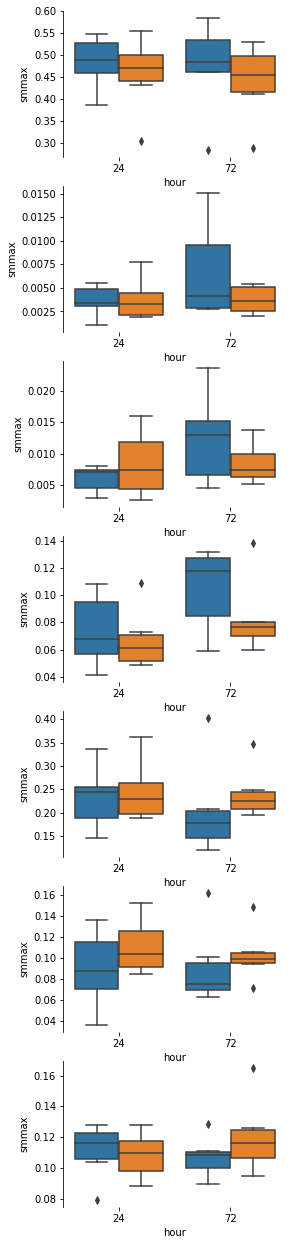

In [29]:
# g = sns.FacetGrid(sr, col="hour", row='sm', )
# g = g.map(sns.boxplot, "smmax")
cc = sr.sm.unique()
plt.figure(figsize=(4,22))
for i in cc:
    plt.subplot(7,1,i + 1)
    tdf = sr[sr['sm'] == i]
    g = sns.boxplot(data=tdf, x='hour', y='smmax', hue='sub')
    sns.despine(top=True, bottom=True)
    g.get_legend().remove()

In [30]:
aggs

sm    dataset  smmax  treatment   bin
0     0  FSS 24h a   4436       4436  4436
1     0  FSS 24h b   3893       3893  3893
2     0  FSS 24h c   4826       4826  4826
3     0  FSS 24h d   3311       3311  3311
4     0  FSS 24h e   4017       4017  4017
5     0  FSS 24h f   4305       4305  4305
6     0  FSS 72h a   4828       4828  4828
7     0  FSS 72h b   2261       2261  2261
8     0  FSS 72h c   3901       3901  3901
9     0  FSS 72h d   4318       4318  4318
10    0  FSS 72h e   3881       3881  3881
11    0  FSS 72h f   1278       1278  1278
12    0  LPS 24h a   2595       2595  2595
13    0  LPS 24h b   4176       4176  4176
14    0  LPS 24h c   4875       4875  4875
15    0  LPS 24h d   4060       4060  4060
16    0  LPS 24h e   3655       3655  3655
17    0  LPS 24h f   3914       3914  3914
18    0  LPS 72h a   2404       2404  2404
19    0  LPS 72h b   4135       4135  4135
20    0  LPS 72h c   4316       4316  4316
21    0  LPS 72h d   3499       3499  3499
22    0  LPS 72h e   3647       3647  3647
23    0  LPS 72h f   4448       4448  4448
24    1  FSS 24h a     25         25    25
25    1  FSS 24h b      9          9     9
26    1  FSS 24h c     32         32    32
27    1  FSS 24h d     28         28    28
28    1  FSS 24h e     47         47    47
29    1  FSS 24h f     45         45    45
..   ..        ...    ...        ...   ...
138   5  LPS 72h a    885        885   885
139   5  LPS 72h b    611        611   611
140   5  LPS 72h c    852        852   852
141   5  LPS 72h d    834        834   834
142   5  LPS 72h e   1259       1259  1259
143   5  LPS 72h f    786        786   786
144   6  FSS 24h a    656        656   656
145   6  FSS 24h b   1096       1096  1096
146   6  FSS 24h c   1087       1087  1087
147   6  FSS 24h d   1037       1037  1037
148   6  FSS 24h e    882        882   882
149   6  FSS 24h f    952        952   952
150   6  FSS 72h a    941        941   941
151   6  FSS 72h b    884        884   884
152   6  FSS 72h c    596        596   596
153   6  FSS 72h d    952        952   952
154   6  FSS 72h e    812        812   812
155   6  FSS 72h f    357        357   357
156   6  LPS 24h a   1015       1015  1015
157   6  LPS 24h b    727        727   727
158   6  LPS 24h c    981        981   981
159   6  LPS 24h d   1105       1105  1105
160   6  LPS 24h e    802        802   802
161   6  LPS 24h f    891        891   891
162   6  LPS 72h a   1381       1381  1381
163   6  LPS 72h b    943        943   943
164   6  LPS 72h c    815        815   815
165   6  LPS 72h d   1040       1040  1040
166   6  LPS 72h e   1067       1067  1067
167   6  LPS 72h f    883        883   883

[168 rows x 5 columns]

In [284]:
aggs.to_csv("/n/core/micro/nro/rop/cjw/Galleries/replicates_20191009.csv")

In [31]:
counts = df1.groupby('gtc').agg({'gtc':['count']}, axis=0)
counts['dataset'] = 'Vortex Clustering'
counts

gtc            dataset
     count                   
gtc                          
0    19450  Vortex Clustering
1     1729  Vortex Clustering
2     2015  Vortex Clustering
3     4899  Vortex Clustering
4     1143  Vortex Clustering
5     3152  Vortex Clustering
6     3081  Vortex Clustering

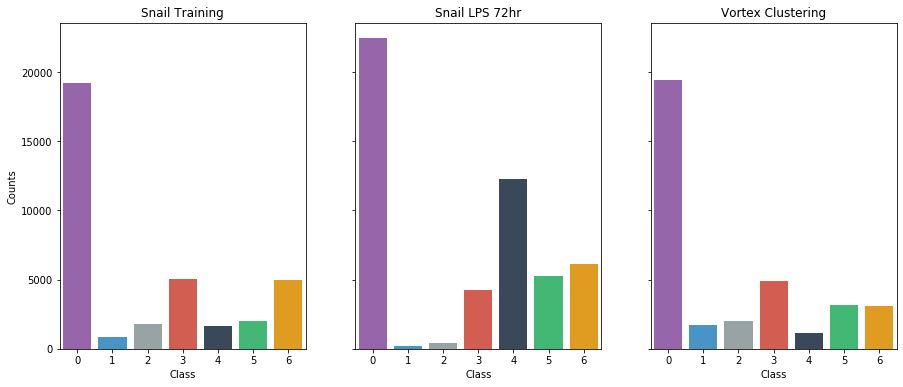

In [38]:
import seaborn as sns 

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "orange"]

fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
fig.set_size_inches(15,6)
#plt.subplot(1,3,1)
sns.countplot(x='sm', data=df1, palette=flatui, ax=ax[0])
ax[0].set_title("Snail Training")
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Counts')
#plt.subplot(1,3,2)
sns.countplot(x='sm', data=adf[adf.treatment=='LPS 72'], palette=flatui, ax=ax[1])
ax[1].set_title("Snail LPS 72hr")
ax[1].set_xlabel('Class')
ax[1].set_ylabel('')
#plt.subplot(1,3,3)
sns.countplot(x='gtc', data=df1, palette=flatui, ax=ax[2])
ax[2].set_title("Vortex Clustering")
ax[2].set_xlabel('Class')
ax[2].set_ylabel('')

plt.savefig('Graphics/counts_lps72.pdf')

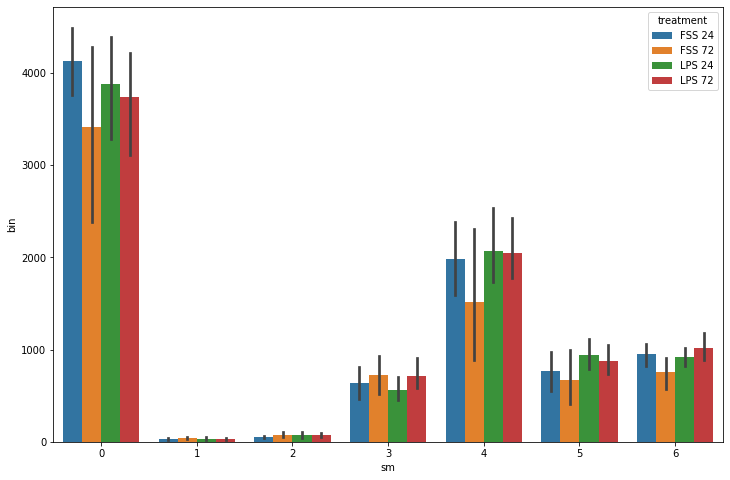

In [43]:
aggs['treatment'] = aggs['dataset'].str.split("h ", expand=True)[0]

plt.figure(figsize=(12, 8))
sns.barplot(x='sm', y='bin', hue='treatment', data=aggs)

In [40]:
aggs.head()

sm    dataset  smmax  treatment   bin
0   0  FSS 24h a   4436       4436  4436
1   0  FSS 24h b   3893       3893  3893
2   0  FSS 24h c   4826       4826  4826
3   0  FSS 24h d   3311       3311  3311
4   0  FSS 24h e   4017       4017  4017

In [35]:
from sklearn import metrics
print(metrics.classification_report(df1['gtc'], df1['sm']))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     19450
           1       0.73      0.35      0.48      1729
           2       0.67      0.59      0.63      2015
           3       0.73      0.75      0.74      4899
           4       0.46      0.67      0.54      1143
           5       0.62      0.39      0.48      3152
           6       0.43      0.70      0.54      3081

   micro avg       0.76      0.76      0.76     35469
   macro avg       0.65      0.62      0.61     35469
weighted avg       0.77      0.76      0.76     35469



In [126]:
dfreps_ = df1.groupby('sm').agg({'smmax':'count'})
reps_ = df1.groupby('gtc').agg({'smmax':'count'})
sr_ = reps_.smmax/len(df1)
reps_, dfreps_

(     smmax
 gtc       
 0    19450
 1     1729
 2     2015
 3     4899
 4     1143
 5     3152
 6     3081,     smmax
 sm       
 0   19174
 1     843
 2    1787
 3    5025
 4    1658
 5    1989
 6    4993)

In [100]:
import umap

emb1 = umap.UMAP(n_neighbors=12, min_dist=.1).fit_transform(d2array)
#emb2 = umap.UMAP(n_neighbors=12, min_dist=.1).fit_transform(r2)
adf['x'] = emb1[:,0]
adf['y'] = emb1[:, 1]

#df2['x'] = emb2[:,0]
#df2['y'] = emb2[:, 1]

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../anaconda3/envs/deep/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


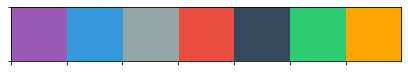

In [101]:
import seaborn as sns

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "orange"]
sns.palplot(sns.color_palette(flatui))

def scatter(df):
    df['s'] = df['smmax']
    df['s'] *= 10
    df['s'] = df['s'].map(int)

    plt.figure(figsize=(8,8))
    sns.scatterplot(x='x', y='y', hue='sm', s=2,
                    alpha=.4, edgecolor=None,
                    palette=flatui, legend='full', data=df)
    


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

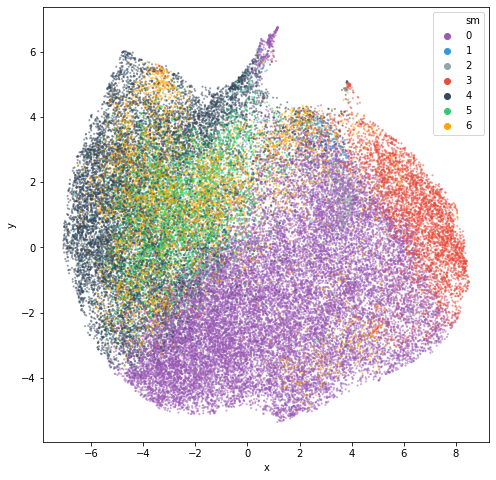

In [108]:
scatter(adf[adf['treatment'] == 'LPS 72'])

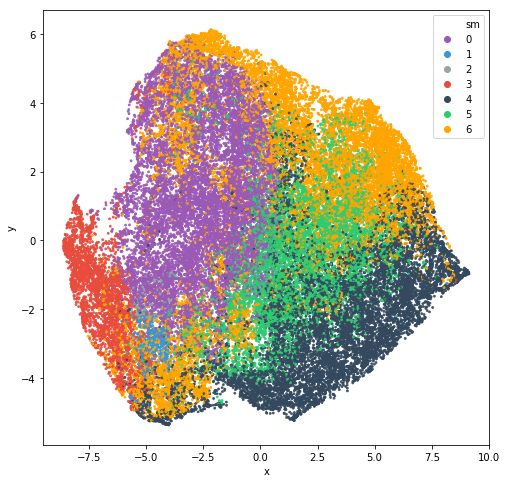

In [89]:
scatter(df2)

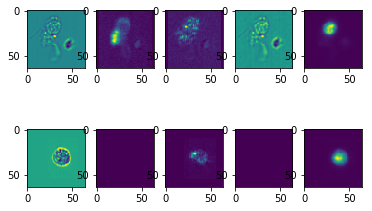

In [16]:
n = 38

for i in range(5):
    plt.subplot(2,5,i + 1)
    plt.imshow(data[n,:,:,i])
    plt.subplot(2,5,i + 1 + 5)
    plt.imshow(amm[n,:,:,i])

In [104]:
adf

sm     smmax    dataset         x         y  s
0      0  0.999982  FSS 24h e  2.504132 -3.969366  9
1      0  0.981270  FSS 24h e  3.646953 -0.330614  9
2      0  0.957932  FSS 24h e  5.677839 -0.679615  9
3      4  0.971556  FSS 24h e -2.666127  4.435254  9
4      5  0.908794  FSS 24h e -2.036177  0.562304  9
5      0  0.791962  FSS 24h e  1.737364  3.334827  7
6      6  0.995296  FSS 24h e -2.394324  2.046618  9
7      0  0.687566  FSS 24h e  2.657469 -3.841390  6
8      0  0.998909  FSS 24h e  4.580183 -1.930697  9
9      0  0.807004  FSS 24h e  1.104221 -0.399460  8
10     0  0.890259  FSS 24h e  1.462395  1.567118  8
11     4  0.544973  FSS 24h e -5.054079  0.424644  5
12     0  0.927871  FSS 24h e  3.253505  2.204159  9
13     0  0.963923  FSS 24h e  0.705009 -3.242893  9
14     6  0.377186  FSS 24h e -2.771440 -1.048580  3
15     0  0.995923  FSS 24h e  2.398976 -2.746312  9
16     4  0.812869  FSS 24h e -2.908978 -2.406261  8
17     0  0.981810  FSS 24h e  1.853391 -2.090513  9
18     0  0.865495  FSS 24h e  0.354836 -1.659220  8
19     3  0.957243  FSS 24h e  6.927585 -0.565189  9
20     6  0.616321  FSS 24h e -4.082293  0.744354  6
21     0  0.949694  FSS 24h e -2.353785 -3.880332  9
22     3  0.999541  FSS 24h e  8.283695  0.399577  9
23     5  0.496217  FSS 24h e -3.646059  4.292560  4
24     5  0.696276  FSS 24h e -3.152469  1.598075  6
25     4  0.998254  FSS 24h e -3.304389  4.543124  9
26     0  0.838105  FSS 24h e -2.399477 -2.695371  8
27     0  0.920220  FSS 24h e -4.289686 -3.914814  9
28     1  0.370365  FSS 24h e  3.093929  2.984362  3
29     6  0.501378  FSS 24h e -5.418336 -2.008910  5
...   ..       ...        ...       ...       ... ..
8567   0  0.879460  LPS 72h b  4.898181 -0.796871  8
8568   0  0.702487  LPS 72h b  6.924985 -1.506339  7
8569   0  0.998687  LPS 72h b  5.737775 -1.274644  9
8570   6  0.879230  LPS 72h b -4.549657  2.177517  8
8571   0  0.629564  LPS 72h b -2.349106 -1.610506  6
8572   4  0.525704  LPS 72h b -1.354261  0.973631  5
8573   0  0.932823  LPS 72h b  3.427372 -3.772251  9
8574   4  0.864022  LPS 72h b -5.912685 -1.105299  8
8575   0  0.814127  LPS 72h b  5.324454 -0.677621  8
8576   6  0.817970  LPS 72h b -1.284610  1.003234  8
8577   4  0.692051  LPS 72h b -4.119873  1.682652  6
8578   0  0.963302  LPS 72h b  4.782377  1.718434  9
8579   3  0.728628  LPS 72h b  6.244334 -0.200800  7
8580   0  0.840532  LPS 72h b -2.646343 -2.879078  8
8581   3  0.994295  LPS 72h b  6.518985  1.510261  9
8582   0  0.986252  LPS 72h b -3.754905 -4.242785  9
8583   0  0.947934  LPS 72h b  1.115655 -0.128054  9
8584   5  0.930515  LPS 72h b -4.943453 -1.949434  9
8585   4  0.644845  LPS 72h b -0.699906  4.126666  6
8586   3  0.702976  LPS 72h b  6.410546  0.845824  7
8587   0  0.818052  LPS 72h b  5.411479 -1.580841  8
8588   0  0.900011  LPS 72h b  0.199098  0.110354  9
8589   6  0.794751  LPS 72h b  3.987303 -1.786857  7
8590   3  0.987426  LPS 72h b  5.409311  2.760948  9
8591   0  0.980996  LPS 72h b  3.204897  1.712895  9
8592   0  0.719353  LPS 72h b  1.405553 -4.138767  7
8593   4  0.585085  LPS 72h b -3.613164 -2.108224  5
8594   4  0.789755  LPS 72h b -3.385482 -2.705814  7
8595   4  0.994802  LPS 72h b -6.376361  1.225884  9
8596   0  0.854053  LPS 72h b  2.288152  3.413732  8

[196311 rows x 6 columns]

In [35]:
cn = 2

def gallery(df, images, cn, threshold):
    xdf = df[df['smmax'] > threshold]
    cnums = xdf[xdf['sm'] == cn].index
    cnums = np.array(cnums)
    np.random.shuffle(cnums)

    index = 1
    counter = 0

    if len(cnums) > 20:
        num_x = 20
    else:
        num_x = len(cnums)

    print(num_x)
    plt.figure(figsize=(4,1.3*num_x))
    for inum in cnums:
        #print(inum)
        #print(p[inum].max())
        for i in range(3):
            plt.subplot(num_x,3,index)
            plt.imshow(images[inum,:,:,i], cmap='gray')
            plt.axis('off')
            index += 1
        counter += 1
        if counter >= 20:
            break

    xdf[xdf['sm'] == cn].head()
    

20
20
20
20
20
20
20
20
20
20
20
20
20
20


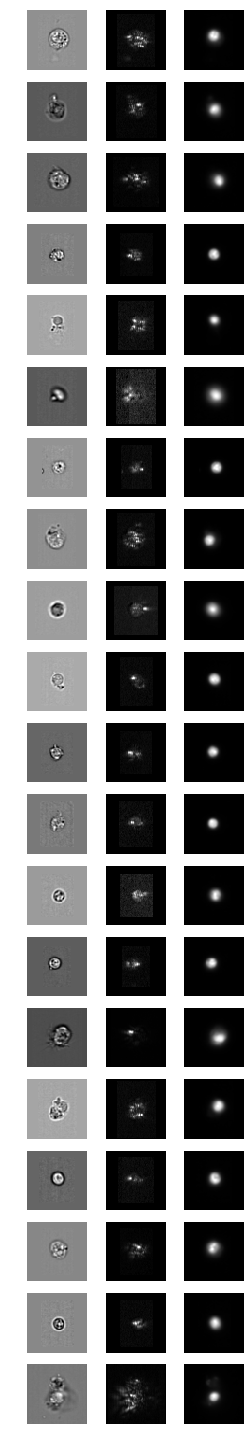

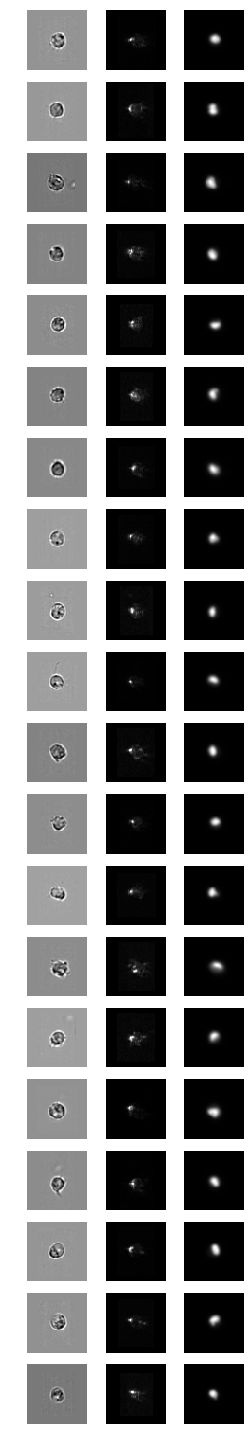

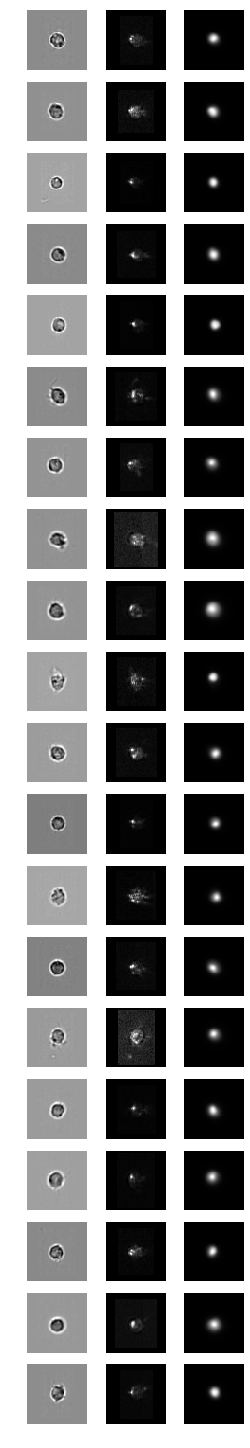

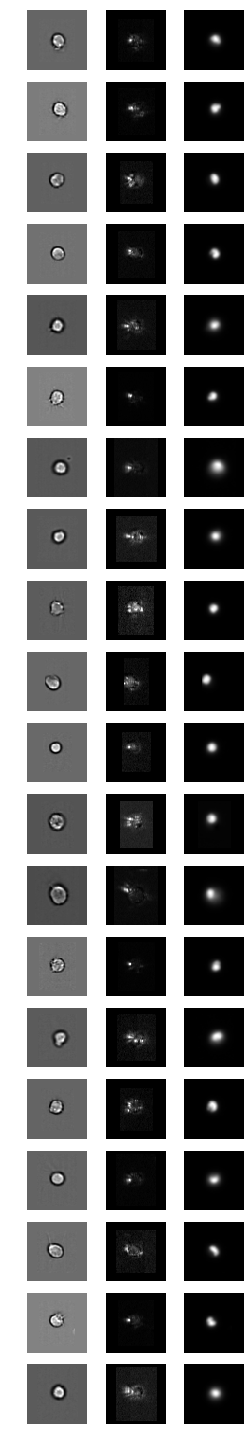

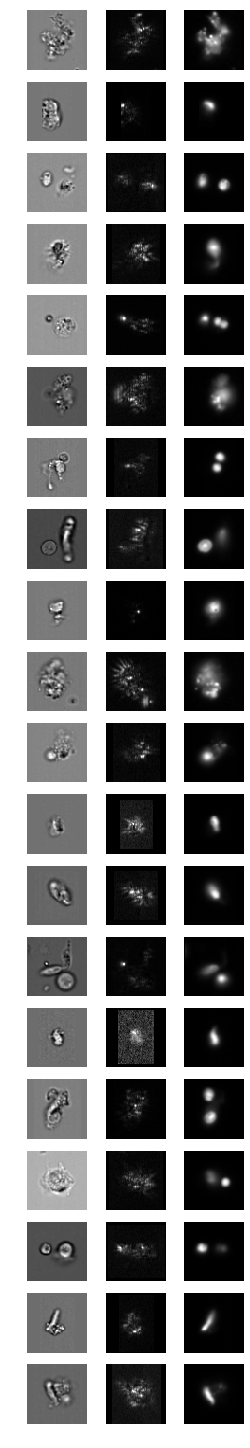

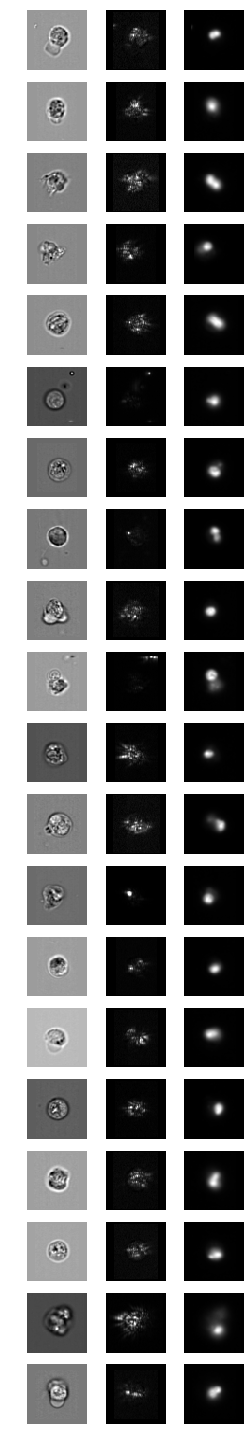

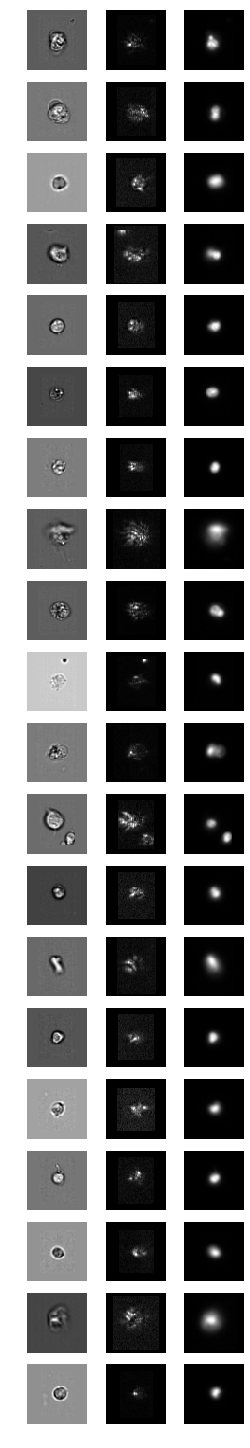

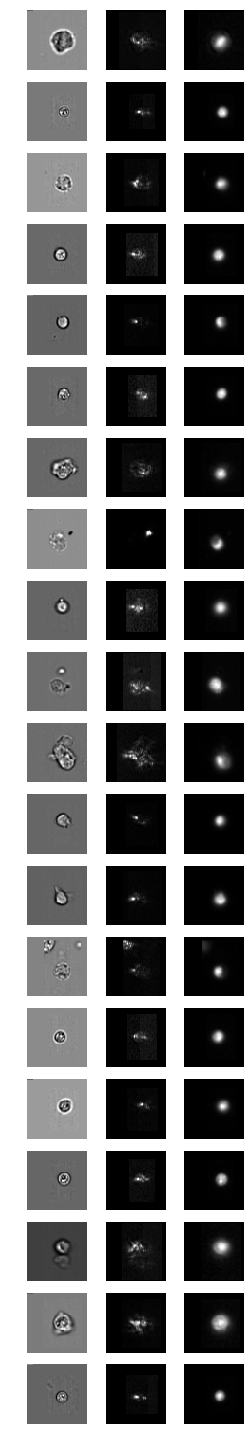

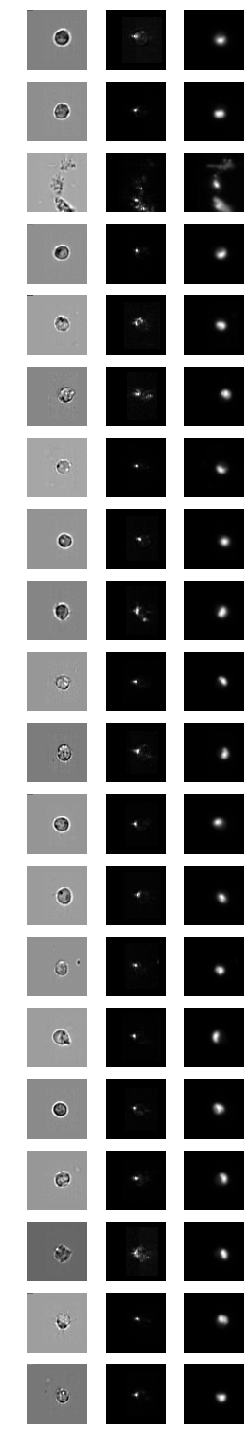

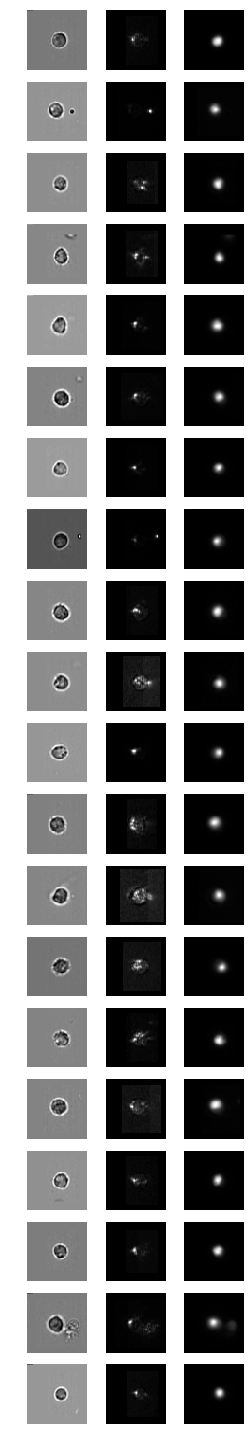

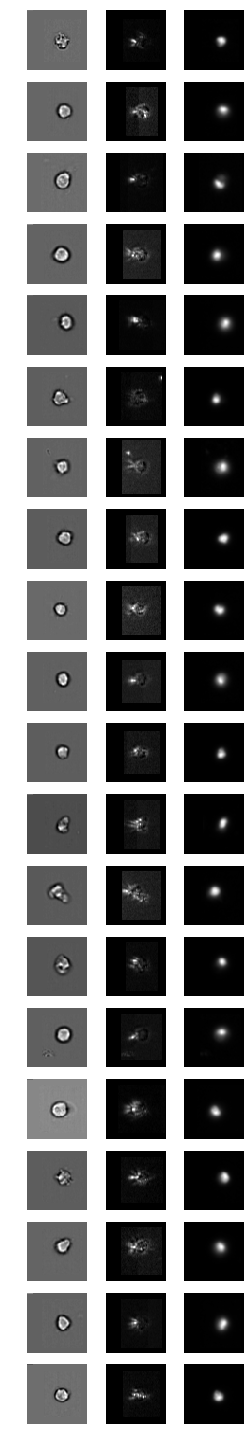

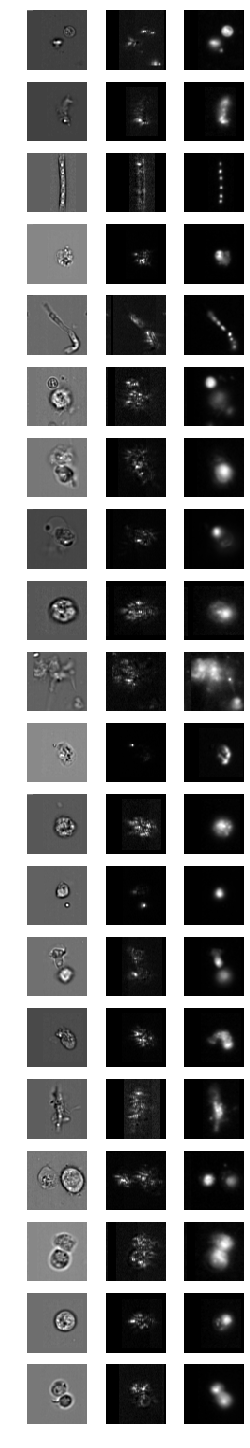

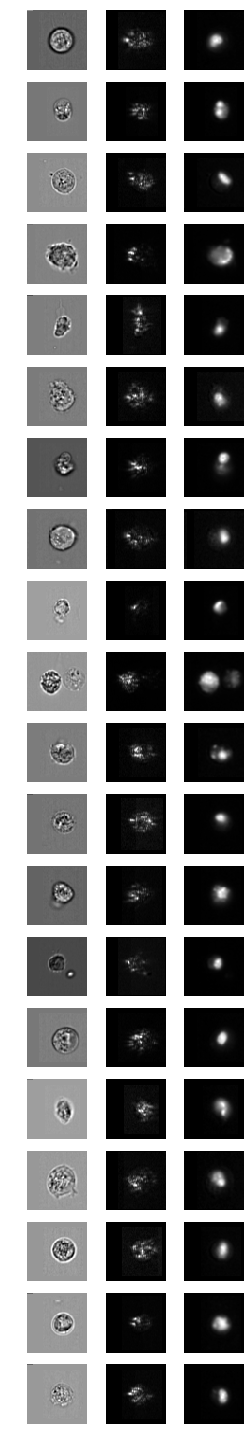

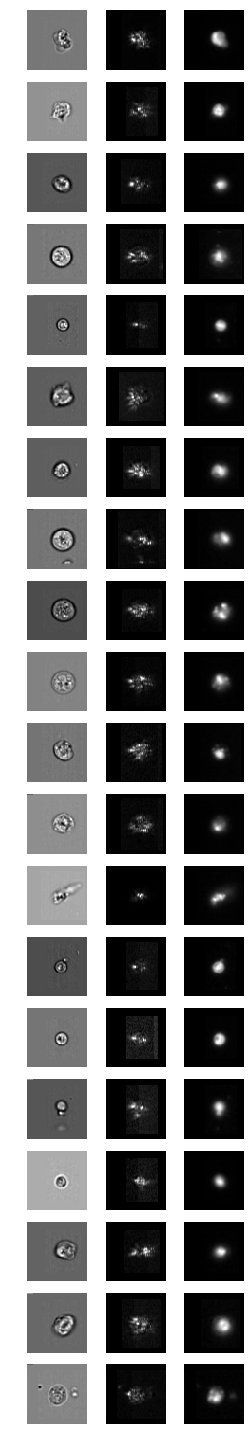

In [137]:
import os

plt.ioff()
gdir = 'Graphics/gallery_fss24/'
try:
    os.makedirs(gdir)
except:
    print('can\'t make directory')
    
for i in range(df1['gtc'].max() + 1):
    gallery(df1, data, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-1', i)
    plt.savefig(fname, bbox_inches='tight')
    
for i in range(df2['sm'].max() + 1):
    gallery(df2, amm, i, .85)
    fname = '{}{}_class_{:02d}.pdf'.format(gdir, 'set-2', i)
    plt.savefig(fname, bbox_inches='tight')
    
plt.ion()

20


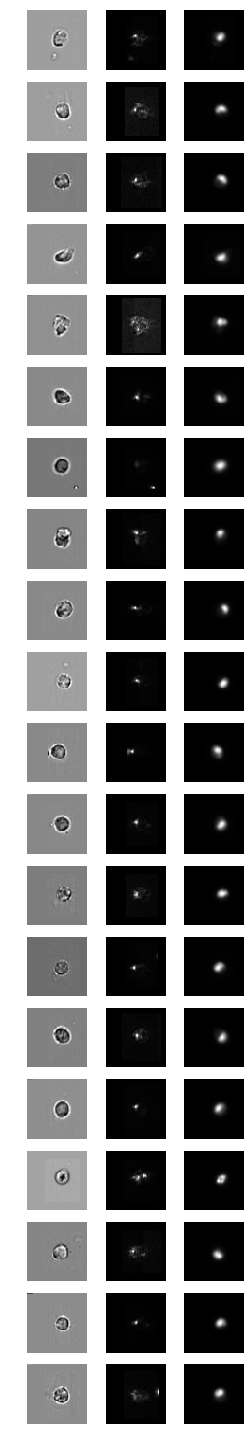

In [37]:
gallery(df2, amm, 1, .85)

In [65]:
from sklearn.manifold import TSNE
ts2 = TSNE().fit_transform(r2)

In [66]:
ts1 = TSNE().fit_transform(r1)

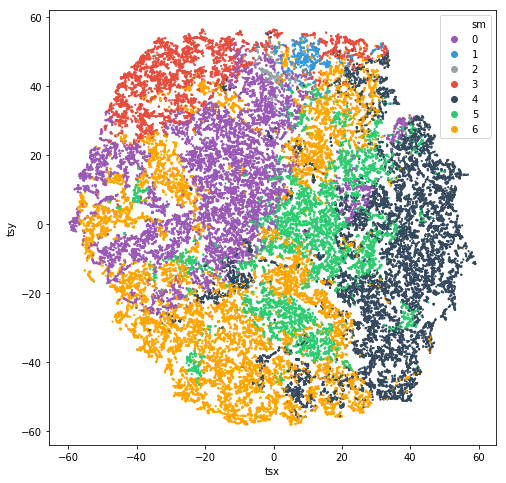

In [69]:

df2['tsx'] = ts2[:,0]
df2['tsy'] = ts2[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df2)

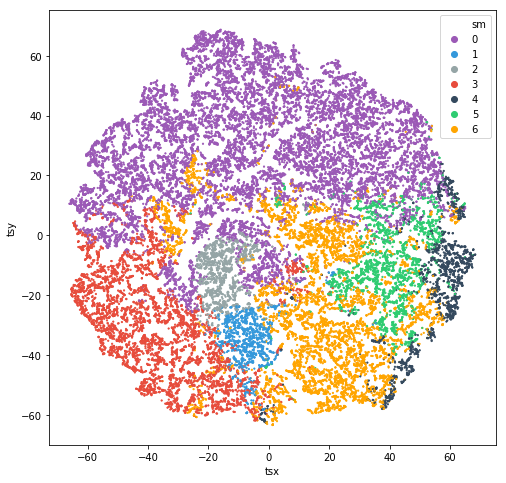

In [70]:
df1['tsx'] = ts1[:,0]
df1['tsy'] = ts1[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(x='tsx', y='tsy', hue='sm', s=2, edgecolor=None, palette=flatui, data=df1)